# Modelling

This notebook is the main modeling notebook. It will take files saved in the `model` of the data configuration and use them to create a predictive model.

## 1. Imports, Configuration and Reading data

### 1.1 Imports

In [1]:
from runner import io 

import pandas as pd
import numpy as np
import altair as alt
from sklearn.linear_model import LinearRegression
import altair as alt
# import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as matplotlib
from scipy.stats import loguniform


from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, PowerTransformer, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import TruncatedSVD

from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score, precision_score, f1_score,roc_auc_score, accuracy_score, r2_score, mean_squared_error, mean_absolute_error


from sklearn.ensemble import RandomForestRegressor, VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBRegressor
from sklearn.neural_network import MLPClassifier

import warnings
warnings.filterwarnings("ignore")

alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

### 1.2 Chart Configuration

In [2]:
from datetime import datetime, timedelta
import json

import pandas as pd
import numpy as np

import altair as alt
alt.data_transformers.disable_max_rows()
alt.renderers.set_embed_options(scaleFactor=5)

# Altair theme setup
def pantanal_palette(key="pantanal_dark_light"):
    color_schemes = {
        'category-6': ['#ec8431', '#829eb1', '#c89d29', '#3580b1', '#adc839', '#ab7fb4'],
        'fire-7': ['#fbf2c7', '#f9e39c', '#f8d36e', '#f4bb6a', '#e68a4f', '#d15a40', '#ab4232'],
        'fireandice-6': ['#e68a4f', '#f4bb6a', '#f9e39c', '#dadfe2', '#a6b7c6', '#849eae'],
        'ice-7': ['#edefee', '#dadfe2', '#c4ccd2', '#a6b7c6', '#849eae', '#607785', '#47525d'],
        "pantanal_dark": ['#0C66B5', '#BA1D32', '#0F8E40', '#E56F20', '#862BAF', '#626D69', '#ED5087'],
        "pantanal_light": ['#3DB9E2', '#51DB63', '#E26868', '#FFB270', '#B37CEA', '#A8A1A4', '#FF87CD'],
    }
    
    color_schemes["pantanal_dark_light"] = color_schemes["pantanal_dark"] + color_schemes["pantanal_light"]
    
    return color_schemes[key]

def science_theme_title(
    font="Helvetica Neue",
    titleFontSize=18,
    subtitleFontSize=14,
    titleFontWeight="normal",
    text=None,
    subtitle=None,
    **kwargs
):
    title_dict = {
        "align": "left",
        "anchor": "start",
        "frame": "group",
        "font": font,
        "fontSize": titleFontSize,
        "dy": -2,
        # Doesn't work directly in config
        "subtitleFont": font,
        "subtitleFontSize": subtitleFontSize,
        "fontWeight": titleFontWeight,
    }
    
    if text is not None:
        title_dict["text"] = text

    if subtitle is not None:
        title_dict["subtitle"] = subtitle
    
    if kwargs:
        title_dict.update(kwargs)

    return title_dict

def science_theme(
    width=1600/3,
    height=900/3,
    font="Helvetica Neue",
    titleFontSize=18,
    titleFontWeight="bold",
    subtitleFontSize=14,
    baseFontSize=14,
):    

    return {
        "config": {
            "view": {
                "width": width,
                "height": height,
                "fill": "white",
            },
            "title": science_theme_title(
                font=font,
                titleFontSize=titleFontSize,
                subtitleFontSize=subtitleFontSize,
            ),
            "axis": {
                "domainColor": "lightGrey",
                "gridColor": "lightGrey",
                "gridWidth": 0.25,
#                 "title": None,
                "titleFont": font,
                "titleFontSize": baseFontSize - 3,
                "labelFont": font,
                "labelFontSize": baseFontSize,
            },
            "legend": {
                "layout": {"anchor": "start"},
                "labelLimit": 0,
                "titleFontSize": baseFontSize,
                "titleFont": font,
                "labelFontSize": baseFontSize,
                "labelFont": font,
            },
            "header": {
                "title": None,
                "titleFont": font,
                "labelFont": font,
                "labelFontSize": baseFontSize,
                "labelPadding": 2,
            },
            "range": {
                "category": pantanal_palette(),
            },
        }
    }

def science_theme_caption(text):
    return (
        alt.Chart(pd.DataFrame(),
                  title={"text": text, **science_theme_title(titleFontSize=12, titleFontWeight="normal")})
        .mark_text()
        .properties(height=1, view={"stroke": None})
    )

def science_theme_facet_title_background(width, fill="lightGrey", opacity=0.25, widthExtra=1):
    return (
        alt.Chart(pd.DataFrame({"a": [0]}))
        .mark_rect(fill=fill, opacity=opacity)
        .encode(y=alt.value(-25), y2=alt.value(-1), x=alt.value(0), x2=alt.value(width + widthExtra))
    )

def science_theme_facet_plot(chart, 
                             title=None, subtitle=None, caption=None,
                             width=300, height=150,
                             facet_kwargs=None, facet_resolve_scales=None,
                             focus_chart=None, focus_chart_width=300, focus_chart_height=150,
                             focus_chart_title="All",
                             focus_chart_resolve_scales=None,
                             grey_facet_background=True,
                             configure_headerColumn=True,
                             **kwargs):
    
    if facet_kwargs is not None:
        if grey_facet_background:
          chart = (chart + science_theme_facet_title_background(width=width))
        chart = chart.facet(**facet_kwargs)

        if facet_resolve_scales is not None:
          chart = chart.resolve_scale(**facet_resolve_scales)
        
        if focus_chart is not None:
            if grey_facet_background: 
              focus_chart = focus_chart + science_theme_facet_title_background(width=focus_chart_width)
            focus_chart = focus_chart.properties(
                width=focus_chart_width, 
                height=focus_chart_height,
                title=science_theme_title(text=focus_chart_title, titleFontSize=14, anchor="middle", offset=-22 if grey_facet_background else 0)
            )
            chart = focus_chart | chart
            
            if focus_chart_resolve_scales is not None:
              chart = chart.resolve_scale(**focus_chart_resolve_scales)
    
    chart = (
        (chart
         # Adding caption
         & science_theme_caption(caption)).resolve_scale(
            x="independent", y="independent", size="independent",
            color="independent", fill="independent", stroke="independent", opacity="independent",
        )
        # Adding title and subtitle
        .properties(title=science_theme_title(text=title, subtitle=subtitle))
        # Configuring plot size
        .configure_view(width=width, height=height)
    )
    
    if (facet_kwargs is not None) and grey_facet_background and configure_headerColumn:
        chart = chart.configure_headerColumn(labelPadding=-20).configure_headerFacet(labelPadding=-20)
    
    return chart
  
def science_theme_weekly_highlights(format="%b %d", tickCount=40): 
    return alt.Axis(
        format=format,
        tickCount=tickCount,
        gridOpacity=alt.condition(
            alt.Predicate(alt.FieldEqualPredicate(field='value', timeUnit="day", equal=1)),
            alt.value(1.0),
            alt.value(0.4)
        ),
    )
    
alt.themes.register("science_theme", science_theme)
alt.themes.enable("science_theme")

ThemeRegistry.enable('science_theme')

### 1.3 Reading Data

In [3]:
df = io.load_table("model", "model_df")
# df = df.drop(columns=["city", "location_UF"])
df = df.drop(columns=["location_UF"])

In [4]:
df = df.sort_values("year").reset_index(drop=True)
df["year"] =df["year"].astype(int)

In [514]:
df

,year,nb_heads_cattle,delta_ha,delta_quantity_ton,delta_nb_heads,delta_quantity_ton_corn_(grain),delta_quantity_ton_others_permanent,delta_quantity_ton_others_temporary,delta_quantity_ton_soybeans_(grain),delta_quantity_ton_sugar_cane,...,fires_ha_2,deforestation_ha_3,nb_heads_cattle_3,fires_ha_3,deforestation_ha_4,nb_heads_cattle_4,fires_ha_4,deforestation_ha_5,nb_heads_cattle_5,fires_ha_5
0,1986,513300.0,0.0,0.0,0.0,312.0,9480.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1986,93300.0,0.0,0.0,0.0,0.0,5475.0,690.0,135.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1986,1418523.0,0.0,0.0,0.0,720.0,0.0,94.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1986,387006.0,0.0,0.0,0.0,4200.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1986,12361.0,0.0,0.0,0.0,90.0,0.0,9.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555,2020,336622.0,0.0,0.0,40402.0,3600.0,0.0,0.0,10800.0,0.0,...,1079.319672,2784.287583,341827.0,5633.482799,4096.700504,334735.0,761.364030,3631.489849,324984.0,905.101171
556,2020,161266.0,0.0,0.0,0.0,525.0,0.0,365.0,245.0,0.0,...,610.530591,775.671301,143711.0,604.949505,789.064611,149114.0,566.743600,876.112554,142010.0,666.893666
557,2020,185903.0,0.0,0.0,0.0,390.0,0.0,0.0,120.0,0.0,...,8695.528655,4404.490030,201497.0,13249.179262,4703.883247,199528.0,8100.548893,5177.168714,181384.0,9334.791398
558,2020,531977.0,0.0,0.0,13290.0,1273.0,0.0,0.0,5399.0,0.0,...,2863.682806,6325.223820,516323.0,13863.462875,4564.344590,505084.0,5708.845375,7062.619519,477965.0,9777.429496


## 2. Modelling

### 2.1 Pipeline and model definition

#### 2.1.1 Prepare data

In [6]:
from runner import io
df = io.load_table("model", "model_df")

In [7]:
df.city.nunique() * df.year.nunique()

560

In [8]:
df.year.nunique()

35

In [9]:
df.city.nunique()

16

In [10]:
# split dataframe in features (X) and target variables (y)
X = df.drop(columns=["deforestation_ha"])
y = df["deforestation_ha"]

In [11]:
#choosing relevant columns to be used in the model (chosen iteratively)
rel_cols = [
    "nb_heads_cattle",
    "delta_nb_heads",
    "delta_quantity_ton_corn_(grain)",
    "delta_quantity_ton_soybeans_(grain)",
    "quantity_ton_corn_(grain)",
    "quantity_ton_soybeans_(grain)",
    "total_area_ha",
    "natural_area_ha",
    "fires_ha",
    "deforestation_ha_1",
    "nb_heads_cattle_1",
    "fires_ha_1",
    "deforestation_ha_2",
    "nb_heads_cattle_2",
    "fires_ha_2",
    "deforestation_ha_3",
    "nb_heads_cattle_3",
    "fires_ha_3",
    "deforestation_ha_4",
    "nb_heads_cattle_4",
    "fires_ha_4",
    "deforestation_ha_5",
    "nb_heads_cattle_5",
    "fires_ha_5",
]

X = X[rel_cols]

#### 2.1.2 Pipeline construction

In [12]:
cat_vars_complete = [i for i in X .columns if X.dtypes[i] == 'object']
num_vars_complete = [i for i in X.columns if X.dtypes[i] == 'float64' or X.dtypes[i] == 'int64']

# ignore_variables = [i for i in num_vars_complete if ("delta" in i or "law" in i)]
# X = X.drop(columns=ignore_variables)
ignore_variables = []

cat_vars = [element for element in cat_vars_complete if (element not in ignore_variables)]
specific_vars = []
num_vars = [element for element in num_vars_complete if (element != 'deforestation_ha' and element not in specific_vars + ignore_variables)]


numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), #ver se tem outro que funciona melhor
    ('scaler', StandardScaler()),
#     ('polynomial_features',PolynomialFeatures(interaction_only=True)),
#     ('pca', PCA())
])

specific_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('power_transform', PowerTransformer(method='yeo-johnson')),
#     ('polynomial_features',PolynomialFeatures(interaction_only=False)),
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
#     ('truncated_svd', TruncatedSVD())
#     ('sparse_pca', sparse_pca),
#     ('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)
    ])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_vars),
        ('cat', categorical_transformer, cat_vars),
#         ('specific', specific_transformer, specific_vars),
    ])


In [527]:
def define_model(cv, type_model="rf", seed=1, random_state=2):
    rf_regressor = RandomForestRegressor(random_state=seed)
    xgb_regressor = XGBRegressor(seed=seed)

    params_xgb = {
        "max_depth": [3, 4, 5, 6, 10, 15, 20],
        "learning_rate": [0.005, 0.01, 0.05, 0.1, 0.2, 0.3],
        "subsample": np.arange(0.1, 1.0, 0.1),
        "colsample_bytree": np.arange(0.4, 1, 0.1),
        "colsample_bylevel": np.arange(0.4, 1, 0.1),
        "n_estimators": [100, 400, 500, 600, 1000],
        # "max_depth": [None, 1, 2, 3, 4, 5, 6],
    }

    # params_xgb = {
    #     "learning_rate": [0.005, 0.01, 0.05, 0.1, 0.2, 0.3],
    #     "subsample": np.arange(0.1, 1.0, 0.1),
    #     "colsample_bytree": np.arange(0.4, 1, 0.1),
    #     "colsample_bylevel": np.arange(0.4, 1, 0.1),
    #     "n_estimators": [100, 400, 500, 600, 1000],
    #     "max_depth": [None, 1, 2, 3, 4, 5, 6, 7, 8],
    # }

    param_dist_rf = {
        "max_depth": [None, 1, 2],
        "max_features": [1,'sqrt'],
        "min_samples_split": [2, 3, 4, 5],
        "min_samples_leaf": [3, 4, 5, 6],
        "n_estimators": [200, 300, 400, 500, 1000],
    }



    rf_random_search = RandomizedSearchCV(rf_regressor, param_distributions=param_dist_rf, scoring="r2",cv=cv, random_state=random_state)
    xgb_random_search = RandomizedSearchCV(xgb_regressor, param_distributions=params_xgb,cv=cv, random_state=random_state)


    xgb = XGBRegressor(
        subsample=0.3,
        n_estimators=500,
        max_depth=15,
        learning_rate=0.05,
        colsample_bytree=0.5,
        colsample_bylevel=0.9,
        random_state=random_state,
    )
 
    rs_rf = Pipeline(
        steps = [
            ('preprocessor', preprocessor),
            ('model', rf_random_search)
            ]
        )

    rs_xgb = Pipeline(
        steps = [
            # ('preprocessor', preprocessor),
            ('model', xgb_random_search)
            ]
        )

    if type_model == "rs_xgb":
        return rs_xgb
    elif type_model == "xgb":
        return xgb
    elif type_model == "rs_rf":
        return rs_rf
    else:
        raise Exception("Please input a valid model!")

In [163]:
#### aux code to help feature selection
# result_dict = {}
# for i in range(36, 0, -1):
#     original_X_it = X.copy()
#     it_dict = {}
#     for column in original_X_it.columns:
#         model_xgb = define_model(tscv.split(X), type_model="xgb", seed=seed, random_state=random_state)
#         X_it = original_X_it.drop(columns=[column])
#         model_xgb.fit(X_it, y)
#         it_dict[model_xgb.best_score_] = column
#     best_score = min(list(it_dict.keys()))
#     column_to_drop = it_dict[best_score]
#     result_dict[i] = (column_to_drop, best_score)
#     print("*"*20 + f"k= {i}" + "*"*20)
#     print(f"Column dropped:{column_to_drop}")
#     print(f"Best score:{best_score}")
#     X = X.drop(columns=[column_to_drop])

#### 2.2.4 Hyper-parameter tuning

In [317]:
split_proportion = 0.6
split_index = int(split_proportion * len(X))

# Split the data
X_train, y_train = X[:split_index], y[:split_index]
X_test, y_test = X[split_index:], y[split_index:]

In [349]:
model_xgb = define_model(tscv.split(X_train), type_model="rs_xgb", seed=5, random_state=5)
model_xgb.fit(X_train, y_train)

Pipeline(steps=[('model',
                 RandomizedSearchCV(cv=<generator object TimeSeriesSplit.split at 0x2ac5e3580>,
                                    estimator=XGBRegressor(base_score=None,
                                                           booster=None,
                                                           callbacks=None,
                                                           colsample_bylevel=None,
                                                           colsample_bynode=None,
                                                           colsample_bytree=None,
                                                           early_stopping_rounds=None,
                                                           enable_categorical=False,
                                                           eval_metric=None,
                                                           gamma=None,
                                                           gpu_id=None,
                                                           grow_policy=None,
                                                           importan...
                                                           reg_alpha=None,
                                                           reg_lambda=None, ...),
                                    param_distributions={'colsample_bylevel': array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                                                         'colsample_bytree': array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                                                         'learning_rate': [0.005,
                                                                           0.01,
                                                                           0.05,
                                                                           0.1,
                                                                           0.2,
                                                                           0.3],
                                                         'max_depth': [3, 4, 5,
                                                                       6, 10,
                                                                       15, 20],
                                                         'n_estimators': [100,
                                                                          400,
                                                                          500,
                                                                          600,
                                                                          1000],
                                                         'subsample': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])},
                                    random_state=5))])

In [350]:
best_params = model_xgb.named_steps['model'].best_params_
best_params

{'subsample': 0.30000000000000004,
 'n_estimators': 500,
 'max_depth': 15,
 'learning_rate': 0.05,
 'colsample_bytree': 0.5,
 'colsample_bylevel': 0.8999999999999999}

#### 2.2.3 Model validation

In [352]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=25)
i = 0
# seed = 159
seed = 42
random_state = 42
# X = X.drop(columns=["year"])
results_list = []
for train_index, test_index in tscv.split(X):
    result_dict = {}
    i += 1

    if i <= 15:
        continue
        
    print("*"*20 + f"SPLIT {i - 15}" + "*"*20)
    # split train test data
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    #define model
    model_rf = define_model(tscv.split(X_train), type_model="rs_rf", seed=seed, random_state=random_state)
    model_xgb = define_model(tscv.split(X_train), type_model="xgb", seed=seed, random_state=random_state)

    #fit and predict values
    model_xgb.fit(X_train, y_train)
    y_pred = model_xgb.predict(X_test)
    y_train_pred = model_xgb.predict(X_train)
    y_baseline = X_test["deforestation_ha_1"]

    result_dict["y_pred"] = y_pred
    result_dict["y_test"] = y_test
    result_dict["X_test"] = X_test
    result_dict["r2_score"] = r2_score(y_test, y_pred)
    result_dict["RMSE"] = mean_squared_error(y_test, y_pred, squared=False)
    result_dict["MAE"] = mean_absolute_error(y_test, y_pred)

    results_list.append(result_dict)
    

    print("-"*20 + "XGBoost" + "-"*20)
    print(f"R2 Score: {r2_score(y_test, y_pred):.2%} (Baseline: {r2_score(y_test, y_baseline):.2%})")
    print(f"R2 Score (Train): {r2_score(y_train, y_train_pred):.2%}")
    print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False):.4} (Baseline: {mean_squared_error(y_test, y_baseline, squared=False):.4})")
    print(f"MAE: {mean_absolute_error(y_test, y_pred):.2} (Baseline: {mean_absolute_error(y_test, y_baseline):.4})")

    # # print("-"*20 + "XGBoost" + "-"*20)
    # print(f"R2 Score: {r2_score(y_test, y_pred):.2%}")
    # # print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}")
    # print(f"R2 Score (Train): {r2_score(y_train, y_train_pred):.2%}")
    # print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False)}")
    # print(f"MAE: {mean_absolute_error(y_test, y_pred)}")


********************SPLIT 1********************
--------------------XGBoost--------------------
R2 Score: 69.21% (Baseline: 51.66%)
R2 Score (Train): 99.95%
RMSE: 4.286e+03 (Baseline: 5.37e+03)
MAE: 2.5e+03 (Baseline: 3.021e+03)
********************SPLIT 2********************
--------------------XGBoost--------------------
R2 Score: 83.68% (Baseline: 90.13%)
R2 Score (Train): 99.94%
RMSE: 2.354e+03 (Baseline: 1.831e+03)
MAE: 1.3e+03 (Baseline: 1.115e+03)
********************SPLIT 3********************
--------------------XGBoost--------------------
R2 Score: 80.38% (Baseline: 82.73%)
R2 Score (Train): 99.95%
RMSE: 3.331e+03 (Baseline: 3.125e+03)
MAE: 2.4e+03 (Baseline: 1.881e+03)
********************SPLIT 4********************
--------------------XGBoost--------------------
R2 Score: 84.45% (Baseline: 91.62%)
R2 Score (Train): 99.96%
RMSE: 3.408e+03 (Baseline: 2.502e+03)
MAE: 2e+03 (Baseline: 1.58e+03)
********************SPLIT 5********************
--------------------XGBoost---------

#### 2.2.4 Confidence interval estimation (Non-overlapping Block bootstrap)

In [353]:
# Initialize a list to store matrices
matrices_list = []

# Iterate through each result in results_list and create matrices
for i, result in enumerate(results_list):
    y_pred = result['y_pred']
    y_test = result['y_test']
    matrix = list(zip(y_pred, y_test))  # Combine y_pred and y_test into pairs
    matrices_list.append(matrix)

In [411]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import random

# Define the number of bootstrap iterations
n_iterations = 500
random_seed = 500
random.seed(random_seed)

# Define a function to calculate RMSE, MAE, and R^2 from concat of blocks
def calculate_metrics_samples_blocks(matrices):
    y_pred = []
    y_test = []
    # concat all diferrent blocks
    for matrix in matrices:
        y_pred.extend(np.array(matrix)[:,0])
        y_test.extend(np.array(matrix)[:,1])

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    return rmse, mae, r2

# Initialize a list to store the results for each bootstrap iteration
bootstrap_results = []

# Perform bootstrapping
for _ in range(n_iterations):
    # Sample blocks with replacement
    sampled_matrices = random.choices(matrices_list, k=len(matrices_list))

    # Calculate metrics for the sampled blocks
    rmse, mae, r2 = calculate_metrics_samples_blocks(sampled_matrices)

    # Store the results
    bootstrap_results.append((rmse, mae, r2))

# Calculate the confidence intervals for RMSE, MAE, and R^2
confidence_intervals = {
    "Metric": ["RMSE", "MAE", "R2 Score"],
    "Lower": [np.percentile([x[0] for x in bootstrap_results], 2.5),
              np.percentile([x[1] for x in bootstrap_results], 2.5),
              np.percentile([x[2] for x in bootstrap_results], 2.5)],
    "Upper": [np.percentile([x[0] for x in bootstrap_results], 97.5),
              np.percentile([x[1] for x in bootstrap_results], 97.5),
              np.percentile([x[2] for x in bootstrap_results], 97.5)]
}

# Create a dataframe or visualization to display the confidence intervals
# You can use Altair or any other visualization library of your choice

confidence_intervals

{'Metric': ['RMSE', 'MAE', 'R2 Score'],
 'Lower': [2666.639546629814, 1544.6933235068022, 0.5065764041477986],
 'Upper': [9602.646949170818, 3999.403440486035, 0.8773282935001896]}

## 3. Plot results

In [412]:
confidence_df = pd.DataFrame(confidence_intervals)
confidence_df

,Metric,Lower,Upper
0,RMSE,2666.639547,9602.646949
1,MAE,1544.693324,3999.403440
2,R2 Score,0.506576,0.877328


In [413]:
import altair as alt

# Create separate charts for RMSE and MAE
mae_chart = alt.Chart(
    confidence_df[confidence_df['Metric'].isin(['MAE'])]
).mark_bar(size=70, opacity=0.7,).encode(
    x=alt.X('Metric:O', axis=alt.Axis(title="Metric")),
    y=alt.Y('Lower:Q', title="Value", scale=alt.Scale(domain=(0,6000))),
    y2='Upper:Q',
    # color="Metric:N"
    # color=alt.Color('Metric:N', scale=alt.Scale(domain=['RMAE', 'MAE'], range=['orange', 'blue']))
).properties(
    width=370,
    height=400,
    title=alt.TitleParams(
        text="Confidence Interval for MAE (95%)",
        subtitle="Block Bootstrap - 1986-2020, for all municipalities"
    )
)

# Create a chart for R2 Score
r2_chart = alt.Chart(confidence_df[confidence_df['Metric'] == 'R2 Score']).mark_bar(size=70, opacity=0.7, color="green").encode(
    x=alt.X('Metric:O', axis=alt.Axis(title="Metric")),
    y=alt.Y('Lower:Q', title="Value",),
    y2='Upper:Q',
    color=alt.value('green')
).properties(
    width=370,
    height=400,
    title=alt.TitleParams(
        text="Confidence Interval for R2 Score (95%)",
        subtitle="Block Bootstrap - 1986-2020, for all municipalities"
    )
)

# # Combine the charts
# final_chart = alt.hconcat(rmse_mae_chart, r2_chart, spacing=20)
# final_chart

In [414]:
r2_chart

alt.Chart(...)

In [415]:
mae_chart

alt.Chart(...)

In [387]:
metrics_df = pd.DataFrame(
    {
        "metric": ["R2 Score", "RMSE", "MAE"],
        "values": [
            [results_list[i]["r2_score"] for i in range(len(results_list))],
            [results_list[i]["RMSE"] for i in range(len(results_list))],
            [results_list[i]["MAE"] for i in range(len(results_list))],
        ],
    }
)

metrics_df = metrics_df.explode("values")

In [406]:
metrics_df.query("metric=='MAE'")["values"].mean()

2520.9680398314513

In [389]:
r2_boxplot = alt.Chart(
    metrics_df.query("metric == 'R2 Score'")
).mark_boxplot(size=70, extent=0.5, opacity=0.7, color="green").encode(
    x=alt.X('metric:O', axis=alt.Axis(title="Metric")),
    y=alt.Y('values:Q',scale=alt.Scale(zero=False)),
    
).configure_axis(
    labelFontSize=12,
    titleFontSize=14
)

final_chart = r2_boxplot.properties(
    width=370,
    height=400,
    title=science_theme_title(
        text="Distribution of R2 scores during the CV iterations", 
        subtitle="1986-2020, k=10, for all municipalities"
    )
)

final_chart

alt.Chart(...)

In [390]:
rmse_mae_boxplot = alt.Chart(
    metrics_df.query("metric != 'R2 Score'")
).mark_boxplot(size=70, extent=0.5, opacity=0.7).encode(
    x=alt.X('metric:O', axis=alt.Axis(title="Metric")),
    y=alt.Y('values:Q',scale=alt.Scale(zero=False)),
    color=alt.Color('metric:O', legend=None, scale=alt.Scale(scheme="tableau10"))
).configure_axis(
    labelFontSize=12,
    titleFontSize=14
)

final_chart = rmse_mae_boxplot.properties(
    width=500,
    height=400,
    title=science_theme_title(
        text="Distribution of RMSE and MAE scores during the CV iterations", 
        subtitle="1986-2020, k=10, for all municipalities"
    )
)

final_chart

alt.Chart(...)

In [538]:
tscv = TimeSeriesSplit(n_splits=25)
train_index_df = pd.DataFrame(
    [
        {
            "cv_iteration": i+1,
            "start_index": train.min(),
            "end_index": train.max(),
        }
        for i, (train, test) in enumerate(tscv.split(X))
        if i>14
    ]
).assign(type_index="train")

test_index_df = pd.DataFrame(
    [
        {
            "cv_iteration": i+1,
            "start_index": test.min(),
            "end_index": test.max(),
        }
        for i, (train, test) in enumerate(tscv.split(X))
        if i>14
    ]
).assign(type_index="test")

complete_df = pd.concat([train_index_df, test_index_df])

gantt_chart = alt.Chart(complete_df).mark_bar(color="blue", opacity=0.7, size=23).encode(
    x='start_index:Q',
    x2='end_index:Q',
    y='cv_iteration:O',
    color="type_index:O"
)

gantt_chart.properties(
    title=science_theme_title(
        text="Time series Cross Validation indexes for 10 splits", 
        subtitle="Applied to our Pantanal Dataset"
    ),
    width=550,
    height=350
)


alt.Chart(...)

In [539]:
final_prediction_df = pd.DataFrame()
for i in range(10):
    y_pred = results_list[i]["y_pred"]
    y_test = results_list[i]["y_test"]
    X_test = results_list[i]["X_test"]
    # info_place_year_df = X_test.drop(columns=["city"]).join(df[["city", "year"]])[["city", "year"]]
    info_place_year_df = X_test.join(df[["city", "year"]])[["city", "year"]]
    plot_df = pd.DataFrame(
    {
        "city": info_place_year_df["city"], 
        "year": info_place_year_df["year"], 
        "y_pred": y_pred,
        "y_test": y_test,
        "cv": str(i),
        "r2_score": r2_score(y_test, y_pred)
    })
    final_prediction_df = pd.concat([final_prediction_df, plot_df])

# final_prediction_df["r2_by_city"] = final_prediction_df.groupby("city").transform()
final_prediction_df["year"] = pd.to_datetime(final_prediction_df["year"], format="%Y")
final_prediction_df.head()

,city,year,y_pred,y_test,cv,r2_score
350,Poconé,2007-01-01,3657.361572,3846.145573,0,0.692093
351,Santo Antônio do Leverger,2007-01-01,9166.848633,4073.438286,0,0.692093
352,Aquidauana,2008-01-01,6148.073730,21699.502186,0,0.692093
353,Bodoquena,2008-01-01,702.003784,431.956477,0,0.692093
354,Corumbá,2008-01-01,28102.271484,24972.093603,0,0.692093


In [540]:
final_prediction_df["max_year_cv"] = final_prediction_df.groupby(["city", "cv"]).year.transform("max")
final_prediction_df["year_cv"] = final_prediction_df["year"]
final_prediction_df

,city,year,y_pred,y_test,cv,r2_score,max_year_cv,year_cv
350,Poconé,2007-01-01,3657.361572,3846.145573,0,0.692093,2008-01-01,2007-01-01
351,Santo Antônio do Leverger,2007-01-01,9166.848633,4073.438286,0,0.692093,2008-01-01,2007-01-01
352,Aquidauana,2008-01-01,6148.073730,21699.502186,0,0.692093,2009-01-01,2008-01-01
353,Bodoquena,2008-01-01,702.003784,431.956477,0,0.692093,2009-01-01,2008-01-01
354,Corumbá,2008-01-01,28102.271484,24972.093603,0,0.692093,2009-01-01,2008-01-01
...,...,...,...,...,...,...,...,...
555,Itiquira,2020-01-01,3289.297119,5638.242208,9,0.310764,2020-01-01,2020-01-01
556,Lambari D'Oeste,2020-01-01,637.012573,6836.369793,9,0.310764,2020-01-01,2020-01-01
557,Nossa Senhora do Livramento,2020-01-01,5220.661133,22896.795000,9,0.310764,2020-01-01,2020-01-01
558,Poconé,2020-01-01,15809.973633,28073.999686,9,0.310764,2020-01-01,2020-01-01


In [541]:
final_prediction_df.loc[
    final_prediction_df["year"] == final_prediction_df["max_year_cv"], 
    "year_cv"
    ] = final_prediction_df.loc[
    final_prediction_df["year"] == final_prediction_df["max_year_cv"], 
    "year_cv"
    ].apply(lambda x: pd.to_datetime(str(x.year) + "-12-12"))

In [542]:
final_prediction_df["cv"] = final_prediction_df["cv"].astype(int) + 1

In [548]:
line_chart_pred = alt.Chart(final_prediction_df).transform_fold(
    fold=['y_pred', 'y_test'], 
    as_=['variable', 'value']
).mark_line().encode(
    x=alt.X('year:T', axis = alt.Axis(format="%Y")),
    y='value:Q',
    # color=alt.Color("variable:O", scale=alt.Scale(scheme="tableau10")),
    strokeDash='variable:O'
)

# area_chart = alt.Chart(final_prediction_df).mark_area(opacity=0.2).encode(
#     x=alt.X("year_cv:T", axis=alt.Axis(labelAngle=-90)),
#     y=alt.value(0),
#     y2=alt.value(200),
#     color=alt.Color("cv:O", scale=alt.Scale(scheme="set2")),
# )


combined_chart = line_chart_pred #+ area_chart

combined_chart.properties(
    width=200,
    height=200,
).facet(
    'city:N',
    columns=4
).resolve_axis(
    # x='independent',
    # y='independent'
).resolve_scale(
    # x='independent',
    # y='independent'
).properties(
    title=science_theme_title(
        text="Deforestation Prediction (ha) for each municipality using data from each CV iteration", 
        subtitle="1986-2020, k=10"
    ),
)


alt.FacetChart(...)

In [423]:
final_prediction_df_w_index = final_prediction_df.reset_index()
final_prediction_df_w_index["r2_score_text"] = "R² = " + final_prediction_df_w_index["r2_score"].apply(lambda x: f"{x*100:.3}%")
final_prediction_df_w_index["cv"] = (final_prediction_df_w_index["cv"].astype(int) + 1).astype(str).str.zfill(2)
final_prediction_df_w_index["cv_text"] = "CV iteration = " + (final_prediction_df_w_index["cv"]).astype(str)
final_prediction_df_w_index

,index,city,year,y_pred,y_test,cv,r2_score,max_year_cv,year_cv,r2_score_text,cv_text
0,350,Poconé,2007-01-01,3657.361572,3846.145573,02,0.692093,2008-01-01,2007-01-01,R² = 69.2%,CV iteration = 02
1,351,Santo Antônio do Leverger,2007-01-01,9166.848633,4073.438286,02,0.692093,2008-01-01,2007-01-01,R² = 69.2%,CV iteration = 02
2,352,Aquidauana,2008-01-01,6148.073730,21699.502186,02,0.692093,2009-01-01,2008-01-01,R² = 69.2%,CV iteration = 02
3,353,Bodoquena,2008-01-01,702.003784,431.956477,02,0.692093,2009-01-01,2008-01-01,R² = 69.2%,CV iteration = 02
4,354,Corumbá,2008-01-01,28102.271484,24972.093603,02,0.692093,2009-01-01,2008-01-01,R² = 69.2%,CV iteration = 02
...,...,...,...,...,...,...,...,...,...,...,...
205,555,Itiquira,2020-01-01,3289.297119,5638.242208,11,0.310764,2020-01-01,2020-12-12,R² = 31.1%,CV iteration = 11
206,556,Lambari D'Oeste,2020-01-01,637.012573,6836.369793,11,0.310764,2020-01-01,2020-12-12,R² = 31.1%,CV iteration = 11
207,557,Nossa Senhora do Livramento,2020-01-01,5220.661133,22896.795000,11,0.310764,2020-01-01,2020-12-12,R² = 31.1%,CV iteration = 11
208,558,Poconé,2020-01-01,15809.973633,28073.999686,11,0.310764,2020-01-01,2020-12-12,R² = 31.1%,CV iteration = 11


In [424]:
final_prediction_df_w_index["residual"] = final_prediction_df_w_index["y_pred"] - final_prediction_df_w_index["y_test"] 

In [425]:
residual_chart = alt.Chart(final_prediction_df_w_index).transform_density(
    'residual',
    as_=['residual', 'density'],
).mark_area(opacity=0.5, color="blue").encode(
    x="residual:Q",
    y='density:Q',
)

residual_line_chart = alt.Chart(final_prediction_df_w_index).transform_density(
    'residual',
    as_=['residual', 'density'],
).mark_line(opacity=0.5, color="black", strokeDash=[2,2]).encode(
    x="residual:Q",
    y='density:Q',
).properties(
    width=400,
    height=400,
    title=science_theme_title(
        text="Density Distribution of the model residuals", 
        subtitle="1986-2020, k=10, for all municipalities"
    )
)
residual_chart + residual_line_chart

alt.LayerChart(...)

In [426]:
line = pd.DataFrame({
    'y_pred': [0, 100000],
    'y_test': [0, 100000],
})

line_chart = alt.Chart(line).mark_line(color= 'black').encode(
    x= 'y_pred',
    y= 'y_test'
)

scatter_chart = alt.Chart(final_prediction_df_w_index).mark_circle(size=60, opacity=0.3, color="blue").encode(
    x=alt.X('y_pred', scale=alt.Scale(domain=[0, 100000])),
    y=alt.Y('y_test', scale=alt.Scale(domain=[0, 100000])),
).properties(
    width=400,
    height=400,
    title=science_theme_title(
        text="Observed Deforestation (ha) vs. Forecasted Deforestation (ha)", 
        subtitle="1986-2020, k=10, for all municipalities"
    )
)

( scatter_chart + line_chart) 

alt.LayerChart(...)

In [427]:

from string import whitespace


line_chart_pred = alt.Chart(final_prediction_df_w_index).transform_fold(
    fold=['y_pred', 'y_test'], 
    as_=['variable', 'value']
).mark_line(color="orange", opacity=0.9).encode(
    x=alt.X('index:Q'),
    y='value:Q',
    color=alt.Color("variable:O", scale=alt.Scale(scheme="tableau10")),
    strokeDash="variable:O"
)

r2_score_text = alt.Chart(final_prediction_df_w_index).mark_text(
    align="left", baseline="top", size=16, color='green', opacity=0.7
).encode(
    x=alt.value(20),  # pixels from left
    y=alt.value(20),  # pixels from top
    text="r2_score_text")

combined_chart = line_chart_pred + r2_score_text

combined_chart.properties(
    width=450,
    height=250
).facet(
    'cv_text',
    columns=2,
).resolve_scale(
    x='independent', 
    # y='independent'
).properties(
    title=science_theme_title(
        text="Comparison between prediction and test deforestation for each CV iteration", 
        subtitle="1986-2020, k=10, for all municipalities",
        titleFontSize=18
    ),
)


alt.FacetChart(...)

In [428]:
df.nb_heads_cattle.describe()

count    5.500000e+02
mean     4.277492e+05
std      4.037977e+05
min      5.300000e+03
25%      1.583092e+05
50%      3.137940e+05
75%      5.498840e+05
max      1.994810e+06
Name: nb_heads_cattle, dtype: float64

## 4. Interpreting the model

In [429]:
seed = 32
random_state = 23
model_xgb = define_model(tscv.split(X), type_model="xgb", seed=seed, random_state=random_state)
model_xgb
model_xgb.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=0.9, colsample_bynode=1, colsample_bytree=0.5,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=15, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=23,
             reg_alpha=0, reg_lambda=1, ...)

In [430]:
# cv_res = model_xgb.cv_results_
# for r2, params in zip(cv_res["mean_test_score"], cv_res["params"]):
#     print(r2, params)

In [431]:
import shap
# Fits the explainer
explainer = shap.Explainer(model_xgb.predict, X)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X)

PermutationExplainer explainer: 561it [02:34,  3.43it/s]                                                                                


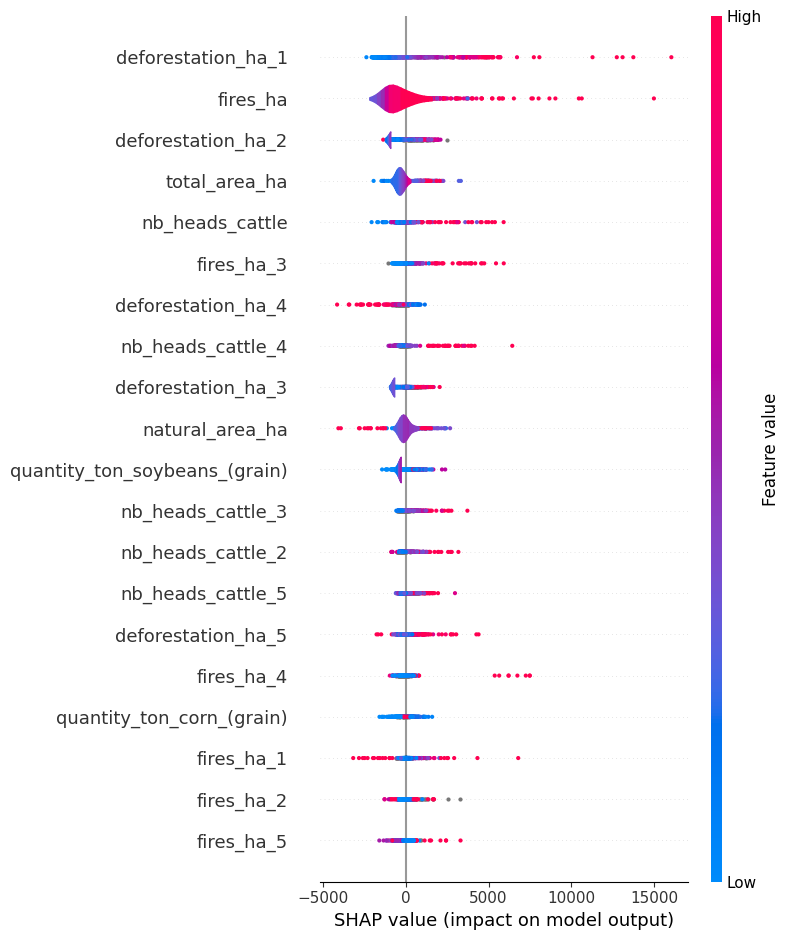

In [432]:
shap.summary_plot(shap_values, plot_type='violin')

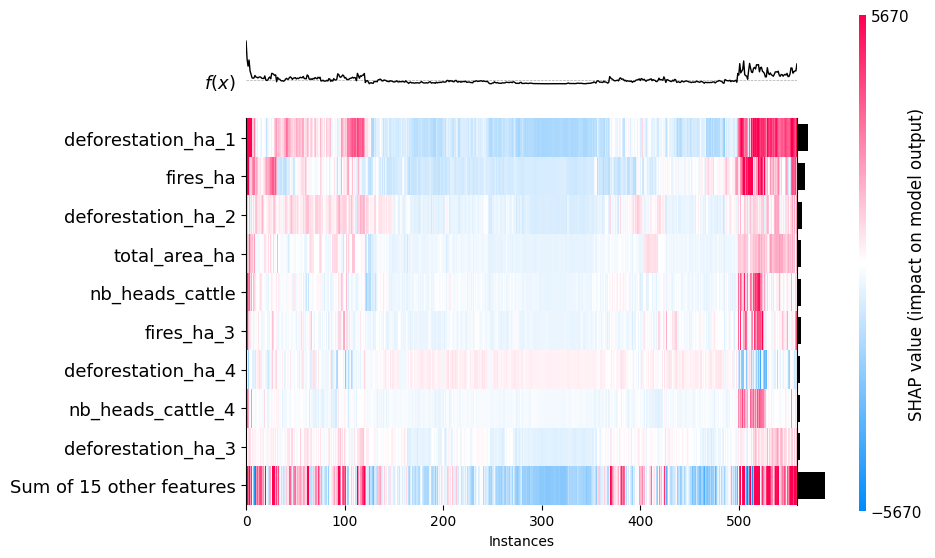

In [433]:
shap.plots.heatmap(shap_values)

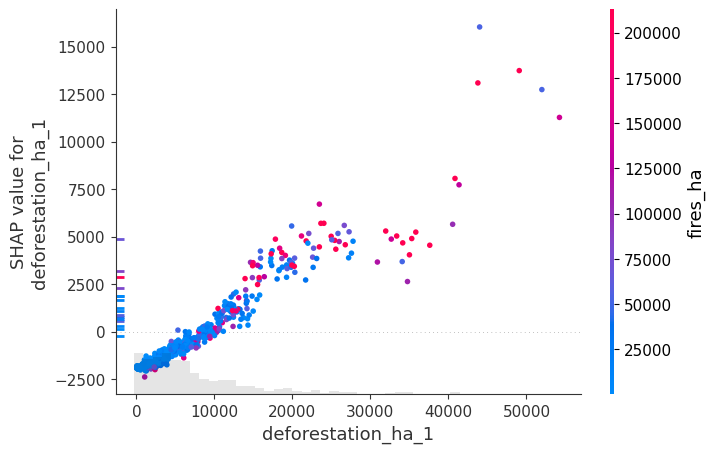

In [447]:
shap.plots.scatter(shap_values[:,"deforestation_ha_1"], color=shap_values)

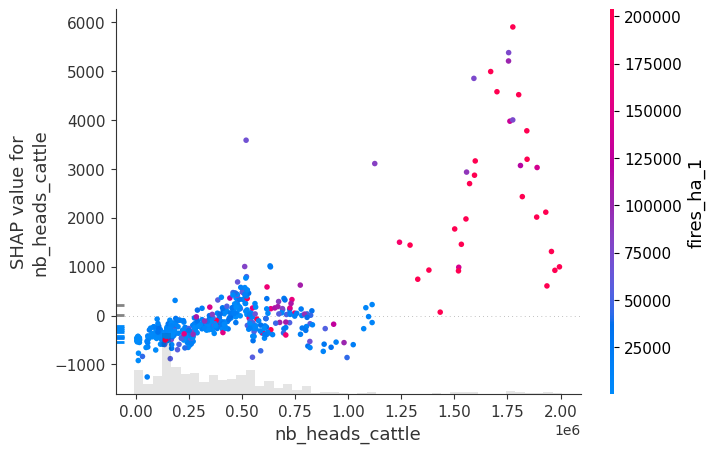

In [448]:
shap.plots.scatter(shap_values[:,"nb_heads_cattle"], color=shap_values)

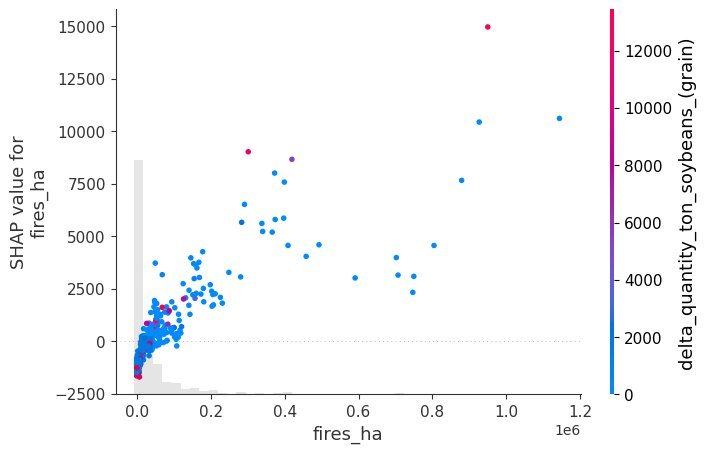

In [449]:
shap.plots.scatter(shap_values[:,"fires_ha"], color=shap_values)

# 5. Predicting future scenarios

In [528]:
seed = 32
random_state = 23
model_xgb = define_model(tscv.split(X), type_model="xgb", seed=seed, random_state=random_state)
model_xgb.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=0.9, colsample_bynode=1, colsample_bytree=0.5,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=15, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=23,
             reg_alpha=0, reg_lambda=1, ...)

In [529]:
from runner import io
df = io.load_table("model", "model_df")
def queimadas_growth(scenario="realistic"):
    if scenario == "realistic":
        year = "2020"
    elif scenario == "optimistic":
        year = "2015"
    else:
        raise ValueError
    aux_df = df.query("year == @year").copy()

    aux_df["growth_1"] = aux_df["fires_ha"] /  aux_df["fires_ha_1"]
    aux_df["growth_2"] = aux_df["fires_ha_1"] /  aux_df["fires_ha_2"]
    aux_df["growth_3"] = aux_df["fires_ha_2"] /  aux_df["fires_ha_3"]
    aux_df["growth_4"] = aux_df["fires_ha_3"] /  aux_df["fires_ha_4"]
    aux_df["growth_5"] = aux_df["fires_ha_4"] /  aux_df["fires_ha_5"]
    melted_df = pd.melt(
        aux_df,
        id_vars=["city"],
        value_vars=[
            "growth_1",
            "growth_2",
            "growth_3",
            "growth_4",
            "growth_5",
            ],
        )

    return melted_df.groupby("city").value.median().reset_index()

queimadas_growth_realistic_df = queimadas_growth(scenario="realistic")
queimadas_growth_optimistic_df = queimadas_growth(scenario="optimistic")

queimadas_growth_optimistic_df

,city,value
0,Aquidauana,1.278202
1,Barão de Melgaço,0.516245
2,Bodoquena,2.529818
3,Corumbá,0.763446
4,Coxim,1.190156
5,Cáceres,1.121860
6,Itiquira,0.627895
7,Ladário,0.581787
8,Lambari D'Oeste,0.798759
9,Miranda,0.521796


In [530]:
projection_vars_growth_rate_dict = dict()
# we suppose that the growth rate in the Pantanal will be similar to the "Centro-Oeste"
# source: FIESP
# for other culturas permanents: let's use orange data (largest permanent)
# for other culturas temporarias, we can use a mean of the growth of cana/soja/milho
projection_vars_growth_rate_dict[2021] = {
        "nb_heads_cattle": 4084/3988,
        # "quantity_ton_sugar_cane": 149615/145299,
        "quantity_ton_corn_(grain)": 54324/52419,
        # "quantity_ton_others_permanent": 172/170,
        "quantity_ton_soybeans_(grain)": 59471/57220,
        # "fires_ha": 1.1
    }
projection_vars_growth_rate_dict[2022] = {
        "nb_heads_cattle": 4202/4084,
        # "quantity_ton_sugar_cane": 160348/149615,
        "quantity_ton_corn_(grain)": 56298/54324,
        # "quantity_ton_others_permanent": 175/172,
        "quantity_ton_soybeans_(grain)": 61817/59471,
        # "fires_ha": 1.1
    }
projection_vars_growth_rate_dict[2023] = {
        "nb_heads_cattle": 4321/4202,
        # "quantity_ton_sugar_cane": 163716/160348,
        "quantity_ton_corn_(grain)": 58345/56298,
        # "quantity_ton_others_permanent": 177/175,
        "quantity_ton_soybeans_(grain)": 64262/61817,
        # "fires_ha": 1.1
    }
projection_vars_growth_rate_dict[2024] = {
        "nb_heads_cattle": 4443/4321,
        # "quantity_ton_sugar_cane": 167729/163716,
        "quantity_ton_corn_(grain)": 60466/58345,
        # "quantity_ton_others_permanent": 180/177,
        "quantity_ton_soybeans_(grain)": 66810/64262,
        # "fires_ha": 1.1
    }
projection_vars_growth_rate_dict[2025] = {
        "nb_heads_cattle": 4566/4443,
        # "quantity_ton_sugar_cane": 173697/167729,
        "quantity_ton_corn_(grain)": 62665/60466,
        # "quantity_ton_others_permanent": 182/180,
        "quantity_ton_soybeans_(grain)": 69466/66810,
        # "fires_ha": 1.1
    }
projection_vars_growth_rate_dict[2026] = {
        "nb_heads_cattle": 4659/4566,
        # "quantity_ton_sugar_cane": 179056/173697,
        "quantity_ton_corn_(grain)": 64944/62665,
        # "quantity_ton_others_permanent": 185/182,
        "quantity_ton_soybeans_(grain)": 72235/69466,
        # "fires_ha": 1.1
    }
projection_vars_growth_rate_dict[2027] = {
        "nb_heads_cattle": 4753/4659,
        # "quantity_ton_sugar_cane": 184328/179056,
        "quantity_ton_corn_(grain)": 67307/64944,
        # "quantity_ton_others_permanent": 188/185,
        "quantity_ton_soybeans_(grain)": 75121/72235,
        # "fires_ha": 1.1
    }
projection_vars_growth_rate_dict[2028] = {
        "nb_heads_cattle": 4847/4753,
        "quantity_ton_sugar_cane": 189475/184328,
        "quantity_ton_corn_(grain)": 69755/67307,
        "quantity_ton_others_permanent": 190/188,
        "quantity_ton_others_temporary": 0.1,
        "quantity_ton_soybeans_(grain)": 78130/75121,
        # "fires_ha": 1.1
    }
projection_vars_growth_rate_dict[2029] = {
        "nb_heads_cattle": 4940/4847,
        # "quantity_ton_sugar_cane": 195925/189475,
        "quantity_ton_corn_(grain)": 72294/69755,
        # "quantity_ton_others_permanent": 193/190,
        "quantity_ton_soybeans_(grain)": 81267/78130,
        # "fires_ha": 1.1
    }
projection_vars_growth_rate_dict[2030] = {
        "nb_heads_cattle": 4940/4847, 
        # "quantity_ton_sugar_cane": 202479/195925,
        "quantity_ton_corn_(grain)": 72294/69755,
        # "quantity_ton_others_permanent": 193/190,
        "quantity_ton_soybeans_(grain)": 81267/78130,
        # "fires_ha": 1.1
    }


# for key in projection_vars_growth_rate_dict.keys():
#     projection_vars_growth_rate_dict[key]["quantity_ton_others_temporary"] = np.mean(
#         [
#             projection_vars_growth_rate_dict[key]["quantity_ton_sugar_cane"],
#             projection_vars_growth_rate_dict[key]["quantity_ton_corn_(grain)"],
#             projection_vars_growth_rate_dict[key]["quantity_ton_soybeans_(grain)"],
#         ]
#     )


In [531]:
def predict_one_year(
    X_completed,
    year, 
    projection_vars_growth_rate_dict, 
    rename_lag_dict, 
    first_lag_var_dict, 
    projection_vars,
    delta_vars,
    queimadas_growth_realistic_df,
    queimadas_growth_optimistic_df,
    scenario
):
    # get projection growth rates for variables
    projection_vars_growth_rate_dict_year = projection_vars_growth_rate_dict[year]

    # define scenario factor
    if scenario == "optimistic":
        scenario_factor = 6/7
        queimadas_df = queimadas_growth_optimistic_df.copy()
    elif scenario == "realistic":
        scenario_factor = 1
        queimadas_df = queimadas_growth_realistic_df.copy()
    elif scenario == "pessimistic":
        scenario_factor = 1.2
        queimadas_df = queimadas_growth_realistic_df.copy()
    else:
        raise ValueError

    # get last_year data: it will be useful to get both lag data and the projections
    last_year = year - 1
    new_X = X_completed.query("year == @last_year").rename(columns=rename_lag_dict)
    new_X = new_X.drop(columns=[col for col in new_X.columns if "_6" in col])

    # get first lag dict, not excluding original var, since it will be used for the projections
    for var, lag_var in first_lag_var_dict.items():
        new_X[lag_var] = new_X[var]

    # get projection using growth determined in the projection_vars_growth_rate_dict
    for var in projection_vars:
        if scenario == "optimistic":
            if var == "nb_heads_cattle":
                new_X[var] = new_X[var] * projection_vars_growth_rate_dict_year[var] * scenario_factor
            else: 
                new_X[var] = new_X[var] * projection_vars_growth_rate_dict_year[var]
        else:
            new_X[var] = new_X[var] * projection_vars_growth_rate_dict_year[var] * scenario_factor

    
    for var in delta_vars:
        if var == "nb_heads_cattle":
            new_X["delta_nb_heads"] = new_X["nb_heads_cattle"] - new_X["nb_heads_cattle_1"]
        else: 
            new_X["delta_" + var] = new_X[var] - new_X[var + "_1"]
            new_X = new_X.drop(columns=[var + "_1"])

    # get new value for natural_area_ha
    new_X["natural_area_ha"] = new_X["total_area_ha"] - new_X["deforestation_ha_1"]

    # assign new year var
    new_X["year"] = year
    
    # get info from queimadas prediction
    new_X["year"] = pd.to_datetime(new_X["year"].astype("str"),format="%Y")
    new_X = new_X.merge(
        queimadas_df, 
        on=["city"], 
        how="left", 
        validate="1:1"
        )


    if scenario == "optimistic": 
        new_X["fires_ha"] = new_X["fires_ha"] * new_X["value"]
    else:  
        new_X["fires_ha"] = new_X["fires_ha"] * new_X["value"] * scenario_factor

    new_X = new_X.drop(columns=["value"])

    predict_X = new_X.drop(columns=["deforestation_ha", "year", "city"])

    
    new_X["deforestation_ha"] = model_xgb.predict(predict_X)

    X_completed_new = pd.concat([X_completed, new_X])

    return X_completed_new

In [532]:
def predict_next_years(X, df, projection_vars_growth_rate_dict, scenario="realistic"):
    # queimadas_prediction_df = io.load_table("model", "queimadas_prediction_df")
    #get city and year data
    X_completed = X.join(df[["city", "year", "deforestation_ha"]])
    X_completed["year"] = pd.to_datetime(X_completed["year"].astype("str"),format="%Y")
    assert max(X_completed.groupby("city").total_area_ha.std()) <= 1e-6, "The join with city is incorrect"

    projection_vars = [
    'nb_heads_cattle', 
    'quantity_ton_corn_(grain)', 
    'quantity_ton_soybeans_(grain)',
    ]

    delta_vars = [
        "quantity_ton_corn_(grain)",
        "quantity_ton_soybeans_(grain)",
        "nb_heads_cattle"
    ]

    lag_vars = [
        'deforestation_ha_1', 'nb_heads_cattle_1', 'fires_ha_1',
        'deforestation_ha_2', 'nb_heads_cattle_2', 'fires_ha_2',
        'deforestation_ha_3', 'nb_heads_cattle_3', 'fires_ha_3',
        'deforestation_ha_4', 'nb_heads_cattle_4', 'fires_ha_4',
        'deforestation_ha_5', 'nb_heads_cattle_5', 'fires_ha_5',
        ]

    rename_lag_dict = {
    original_var: 
        original_var[:-1] + str(int(original_var[-1]) + 1)
    for original_var in lag_vars
    }

    #TODO: include natural_ha

    first_lag_var_dict = {
            "deforestation_ha": "deforestation_ha_1", 
            "nb_heads_cattle": "nb_heads_cattle_1", 
            "fires_ha": "fires_ha_1", 
            "quantity_ton_corn_(grain)": "quantity_ton_corn_(grain)_1",
            "quantity_ton_soybeans_(grain)": "quantity_ton_soybeans_(grain)_1",
        }

    
    for year in range(2021, 2031):
        X_completed = predict_one_year(
            X_completed,
            year,
            projection_vars_growth_rate_dict,
            rename_lag_dict,
            first_lag_var_dict,
            projection_vars,
            delta_vars,
            queimadas_growth_realistic_df, 
            queimadas_growth_optimistic_df,
            scenario,
        )
    
    return X_completed

In [533]:
X_pred_optimistic = predict_next_years(
    X, df, projection_vars_growth_rate_dict, scenario="optimistic"
    ).assign(type_prediction="optimistic")
X_pred_baseline = predict_next_years(
    X, df, projection_vars_growth_rate_dict, scenario="realistic"
    ).assign(type_prediction="realistic")
X_pred_pessimistic = predict_next_years(
    X, df, projection_vars_growth_rate_dict, scenario="pessimistic"
    ).assign(type_prediction="pessimistic")

In [534]:
X_plot = pd.concat([X_pred_baseline, X_pred_optimistic.query("year.dt.year >= 2020"),  X_pred_pessimistic.query("year.dt.year >= 2020")])
X_plot["prediction"] = X_plot["year"].dt.year >= (2021)
X_plot = pd.concat([X_plot, X_plot.query("year == '2020'").assign(prediction=True)])

line_chart = alt.Chart(X_plot).mark_line().encode(
    x=alt.X('year:T', axis = alt.Axis(format="%Y")),
    y='deforestation_ha:Q',
    color="type_prediction:N",
    strokeDash="prediction:N"
)

combined_chart = line_chart

combined_chart.properties(
    width=200,
    height=200
).facet(
    'city:N',
    columns=4
).resolve_axis(
    # x='independent',
    # y='independent'
).resolve_scale(
    # x='independent',
    # y='independent'
).properties(
    title=science_theme_title(
        text="Forecasting of deforestation until 2030 by muncipality", 
        subtitle="For the 3 scenarios: realistic, optimistic and pessimistic",
        titleFontSize=18
    ),
)


alt.FacetChart(...)

In [535]:
agg_X_plot = X_plot.groupby(["year", "type_prediction", "prediction"]).deforestation_ha.sum().reset_index()

line_chart = alt.Chart(agg_X_plot).mark_line().encode(
    x=alt.X('year:T', axis = alt.Axis(format="%Y")),
    y='deforestation_ha:Q',
    color="type_prediction:N",
    strokeDash="prediction:N"
)

combined_chart = line_chart

combined_chart.properties(
    width=550,
    height=400
).resolve_axis(
    # x='independent',
    # y='independent'
).resolve_scale(
    # x='independent',
    # y='independent'
).properties(
    title=science_theme_title(
        text="Aggregated Forecasting of deforestation until 2030", 
        subtitle="For the 3 scenarios: realistic, optimistic and pessimistic",
        titleFontSize=18
    ),
)


alt.Chart(...)

In [536]:
agg_X_plot.query("prediction").groupby("type_prediction")["deforestation_ha"].sum().reset_index().assign(proportion_natural_area=lambda x: x["deforestation_ha"]/15266739.78614)

,type_prediction,deforestation_ha,proportion_natural_area
0,optimistic,1.820089e+06,0.119219
1,pessimistic,4.506394e+06,0.295177
2,realistic,3.408745e+06,0.223279
